# Artificial Intelligence II - Homework 2
---
###Δημήτριος Σιταράς | 1115201800178
---

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

!pip install tweet-preprocessor

In [2]:
def lossCurve(trainLosses,valLosses):
  plt.plot(trainLosses, color="r")
  plt.plot(valLosses, color="g")
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train Loss','Validation Loss'])
  plt.show()

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def rocCurve(validation_prediction,yValidation):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes=3
  validationPrediction=validation_prediction.detach().numpy()
  yLabelsBin = label_binarize(yValidation, classes=[0,1,2])
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(yLabelsBin[:,i], validationPrediction[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  lw = 2
  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(n_classes), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

Οι παρακάτω συναρτήσεις χρησιμοποιούνται για την προεπεξεργασία/καθάρισμα των δεδομένων (δηλαδή των tweets) και συγκεκριμένα:



*   Η συνάρτηση cleaning(...) χρησιμοποιείται για τον καθαρισμό των urls και των mentions απο τα tweets (γι'αυτό τον σκοπό εγκαθιστώ και χρησιμοποιώ τον tweet-preprocessor). Επίσης, μέσω της συνάρτησης αυτής αφαιρώ από τα tweets τα emojis, τα σημεία στίξης και οποιαδήποτε σύμβολα.
*    Η συνάρτηση stemming(...) χρησιμοποιείται για να μειώσει την κλίση των λέξεων του κάθε tweet στην ρίζα ή την βάση τους. Γι'αυτό τον σκοπό χρησιμοποιώ τον SnowBallStemmer.
*    Η συνάρτηση lemmatization(...) χρησιμοποιείται για την "ομαδοποίηση" των λέξεων του κάθε tweet στo λήμμα τους, ώστε να μπορούν να αναλυθούν ως ένα ενιαίο στοιχείο.

In [4]:
import string
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import preprocessor as p
nltk.download('wordnet')

def cleaning(text):
    # used to clean urls, mentions (with @), emojis, punctuation marks and all the other symbols that exist
    p.set_options(p.OPT.URL,p.OPT.MENTION)
    text = p.clean(text)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", text).split())

def stemming(text):
    # used to reduce the inflection in words to their root 
    # SnowBallStemmer used for this job
    SnowStemmer = SnowballStemmer("english")
    stemmedΤokens = [SnowStemmer.stem(token) for token in text.split()]
    return ' '.join(stemmedΤokens)

def lemmatization(text):
    # used to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stringList = [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
    return ' '.join([str(element) for element in stringList])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Οι παρακάτω συναρτήσεις χρησιμοποιούνται για να παραχθούν οι αναπαραστάσεις των tweets μέσω του pre-trained μοντέλου.

Πιο συγκεκριμένα:
* Η συνάρτηση findTweetsFeatureVectors καλεί την συνάρτηση findAverageVector για κάθε ένα tweet έτσι ώστε να δημιουργηθεί η αναπαράσταση του.
* Η συνάρτηση findAverageVector δημιουργεί την αναπαράσταση ενός tweet. Δηλαδή για κάθε μια λέξη που περιέχεται στο tweet βρίσκει το διάνυσμα που αντιστοιχεί στην λέξη αυτή από το GloVe λεξικό που έχω φτίαξει. Αφού βρεθούν τα διανύσματα όλων των λέξεων του tweet, υπολογίζεται ο μέσος όρος τους και προκύπτει το τελικό διάνυσμα που  αναπαριστά το tweet, το οποίο επιστρέφεται.

In [5]:
def findAverageVector(words, vocab, features): # find the average vector of the words of a given tweet
    # average the word vectors for a set of words
    featureVec = np.zeros((features,),dtype="float32") # initialize
    nwords = 0.
 
    for word in words: # for every word of the tweet
        if word in vocab: # if dictionary/vocab contains that word
            nwords = nwords + 1.
            featureVec = np.add(featureVec,vocab[word]) # add the vector of this word to the total vector

    if nwords > 0:
      featureVec = np.divide(featureVec, nwords) # find the average of the total vector
    return featureVec 


def findTweetsFeatureVectors(tweets, vocab, features): # find the average feature vector for every tweet
    # calculate average feature vectors for the given tweets
    i = 0
    tweetFeatureVecs = np.zeros((len(tweets),features), dtype='float32') # initialize
    
    for tweet in tweets:
        tweetFeatureVecs[i] = findAverageVector(tweet, vocab, features)
        i = i + 1
    return tweetFeatureVecs

## Data Loading and Preprocessing

In [6]:
Location = r'vaccine_train_set.csv'
trainDf=pd.read_csv(Location)
Location = r'vaccine_validation_set.csv' 
validationDf=pd.read_csv(Location)

In [7]:
trainDf['tweet'] = trainDf['tweet'].apply(cleaning)
trainDf['tweet'] = trainDf['tweet'].apply(lemmatization)

validationDf['tweet'] = validationDf['tweet'].apply(cleaning)
validationDf['tweet'] = validationDf['tweet'].apply(lemmatization)


In [8]:
tweetsTrain=list(trainDf['tweet'])
labelsTrain=list(trainDf['label'])

tweetsVal=list(validationDf['tweet'])
labelsVal=list(validationDf['label'])

## Vectorization with pre-trained word embedding vectors using GloVe (for the first model)


Χρησιμοποιώ το αρχείο glove.twitter.27B.100d.txt, στο οποίο υπάρχουν λέξεις που αναπαριστόνται απο διανύσματα 100 διαστάσεων. Κάθε γραμμή του αρχείου περιέχει ως πρώτο στοιχείο μια λέξη ακολουθούμενη απο 100 πραγματικούς αριθμούς.
Για το αρχείο αυτο κατασκευάζω ένα dictionary που αντιστοιχίζει ουσιαστικά κάθε λέξη με το διανύσματά της.

In [9]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [10]:
!unzip glove.twitter.27B.zip

In [11]:
embeddingsIndex = {}
f = open('glove.twitter.27B.100d.txt', encoding='utf-8')
for line in f:

    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddingsIndex[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddingsIndex))

Found 1193514 word vectors.


Κατασκευάζω τις αναπαραστάσεις του Train και του Validation set. Οι συγκεκριμένες αναπαραστάσεις θα χρησιμοποιηθούν για το 1ο μοντέλο.

In [12]:
xTrainTokens = [sent.lower().split() for sent in tweetsTrain]
xValidationTokens = [sent.lower().split() for sent in tweetsVal]
trainDataVecs = findTweetsFeatureVectors(xTrainTokens, embeddingsIndex,100)
validationDataVecs  = findTweetsFeatureVectors(xValidationTokens, embeddingsIndex, 100)
print("Glove train shape:", trainDataVecs.shape)
print("Glove validation shape:", validationDataVecs.shape)

Glove train shape: (15976, 100)
Glove validation shape: (2282, 100)


## Vectorization with TF-IDF (for the second model)
Κατασκευάζω πίνακες Tf-idf για για το Train και το Validation set. Οι συγκεκριμένες αναπαραστάσεις θα χρησιμοποιηθούν για το 2ο μοντέλο.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(max_df=0.95, min_df=0.01, ngram_range=(1,2)) #initialize the TfidfVectorizer

tfidfTrain = tfidfVectorizer.fit_transform(tweetsTrain)
tfidfTrain = tfidfTrain.toarray()

tfidfVal = tfidfVectorizer.transform(tweetsVal)
tfidfVal = tfidfVal.toarray()

print("TF-IDF train shape:", tfidfTrain.shape)
print("TF-IDF validation shape:", tfidfVal.shape)

TF-IDF train shape: (15976, 279)
TF-IDF validation shape: (2282, 279)


## Convert to Tensors

In [14]:
xTrainGlove = torch.tensor(trainDataVecs, dtype=torch.float)
yTrainGlove = torch.tensor(labelsTrain, dtype=torch.long)
yTrainGlove = torch.squeeze(yTrainGlove)

xValidationGlove = torch.tensor(validationDataVecs, dtype=torch.float)
yValidationGlove = torch.tensor(labelsVal, dtype=torch.long)
yValidationGlove = torch.squeeze(yValidationGlove)

In [15]:
xTrainTfidf = torch.tensor(tfidfTrain, dtype=torch.float)
yTrainTfidf = torch.tensor(labelsTrain, dtype=torch.long)
yTrainTfidf = torch.squeeze(yTrainTfidf)

xValidationTfidf = torch.tensor(tfidfVal, dtype=torch.float)
yValidationTfidf = torch.tensor(labelsVal, dtype=torch.long)
yValidationTfidf = torch.squeeze(yValidationTfidf)

## Neural Network


In [16]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, D_out)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)

        x = self.linear2(x)
        x = self.relu2(x)

        x = self.linear3(x)
        x = self.relu3(x)
        
        x = self.linear4(x)
        x = self.softmax(x)
        return x
  

## Initialize the 1st Model

In [17]:
D_in = xTrainGlove.shape[1]
H1 = 32
H2 = 16
H3 = 8
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4

#Initialize modelGlove, loss, optimizer
modelGlove = Net(D_in, H1, H2, H3, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelGlove.parameters(), lr=learning_rate)

batch_size=100
#Initialize dataloader
datasetGlove = torch.utils.data.TensorDataset(xTrainGlove, yTrainGlove)
dataloaderGlove = torch.utils.data.DataLoader(datasetGlove, batch_size, shuffle=True)
#Initialize validationloader
validationsetGlove = torch.utils.data.TensorDataset(xValidationGlove, yValidationGlove)
validationloaderGlove = torch.utils.data.DataLoader(validationsetGlove, batch_size, shuffle=False)

In [18]:
modelGlove

Net(
  (linear1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=16, out_features=8, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=8, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

## Train the 1st Model

In [19]:
trainLosses=[]
valLosses=[]
for epoch in range(100):
  batchLosses = []
  for x_batch, y_batch in dataloaderGlove:
    y_pred = modelGlove(x_batch)
    trainLoss = loss_func(y_pred, y_batch)
    batchLosses.append(trainLoss.item())
       
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    trainLoss.backward()
    #Update modelGlove's weights based on the gradients calculated during backprop
    optimizer.step()

  current = sum(batchLosses)/len(dataloaderGlove)
  # print(f"Epoch {epoch:3}: Train Loss = {current:.5f}")
  trainLosses.append(current) 
  
  modelGlove.eval()
  batchLosses = []
  for x_batch, y_batch in validationloaderGlove:
    y_pred = modelGlove(x_batch)
    valLoss = loss_func(y_pred, y_batch)
    batchLosses.append(valLoss.item())
    
  current = sum(batchLosses)/len(validationloaderGlove)
  # print(f"Epoch {epoch:3}: validation Loss = {current:.5f}")
  valLosses.append(current) 

## Accuracy, Precision, Recall, F1-Score, Support, Loss and Roc Curves for the 1st Model

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
validation_prediction=modelGlove(xValidationGlove.float())
_, predicted = torch.max(validation_prediction.data, 1)
correct = (yValidationGlove == predicted).float() 
acc = correct.sum() / len(correct)

print('Accuracy: {}'.format(acc*100))

print(classification_report(yValidationGlove,predicted))


Accuracy: 65.60035705566406
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1065
           1       0.00      0.00      0.00       296
           2       0.58      0.77      0.66       921

    accuracy                           0.66      2282
   macro avg       0.44      0.50      0.47      2282
weighted avg       0.58      0.66      0.61      2282



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


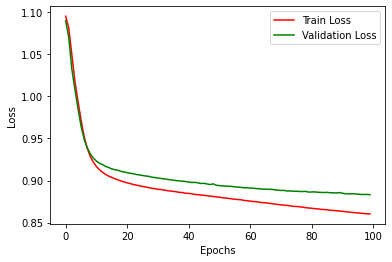

In [21]:
lossCurve(trainLosses,valLosses)

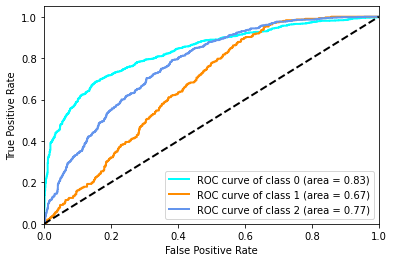

In [22]:
rocCurve(validation_prediction,yValidationGlove)

## Initialize the 2nd Model

In [23]:
D_in = xTrainTfidf.shape[1]
H1 = 32
H2 = 16
H3 = 8
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4

#Initialize modelTfIdf, loss, optimizer
modelTfidf = Net(D_in, H1, H2, H3, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelTfidf.parameters(), lr=learning_rate)

#Initialize dataloader
datasetTfidf = torch.utils.data.TensorDataset(xTrainTfidf, yTrainTfidf)
dataloaderTfidf = torch.utils.data.DataLoader(datasetTfidf, batch_size=100, shuffle=True)
#Initialize validationloader
validationsetTfidf = torch.utils.data.TensorDataset(xValidationTfidf, yValidationTfidf)
validationloaderTfidf = torch.utils.data.DataLoader(validationsetTfidf, batch_size=100, shuffle=False)

In [24]:
modelTfidf

Net(
  (linear1): Linear(in_features=279, out_features=32, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=16, out_features=8, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=8, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

## Train the 2nd Model

In [25]:
trainLosses=[]
valLosses=[]
for epoch in range(100):
  batchLosses = []
  for x_batch, y_batch in dataloaderTfidf:
    y_pred = modelTfidf(x_batch)
    trainLoss = loss_func(y_pred, y_batch)
    batchLosses.append(trainLoss.item())
       
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    trainLoss.backward()
    #Update modelTfidf's weights based on the gradients calculated during backprop
    optimizer.step()

  current = sum(batchLosses)/len(dataloaderTfidf)
  # print(f"Epoch {epoch:3}: Train Loss = {current:.5f}")
  trainLosses.append(current) 
  
  modelTfidf.eval()
  batchLosses = []
  for x_batch, y_batch in validationloaderTfidf:
    y_pred = modelTfidf(x_batch)
    valLoss = loss_func(y_pred, y_batch)
    batchLosses.append(valLoss.item())

    
  current = sum(batchLosses)/len(validationloaderTfidf)
  # print(f"Epoch {epoch:3}: Validation Loss = {current:.5f}")
  valLosses.append(current)     

## Accuracy, Precision, Recall, F1-Score, Support, Loss and Roc Curves for the 2nd Model

In [26]:
from sklearn.metrics import classification_report
validation_prediction=modelTfidf(xValidationTfidf.float())
_, predicted = torch.max(validation_prediction.data, 1)
correct = (yValidationTfidf == predicted).float() 
acc = correct.sum() / len(correct)

print('Accuracy: {}'.format(acc*100))

print(classification_report(yValidationTfidf,predicted))

Accuracy: 66.2576675415039
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      1065
           1       0.00      0.00      0.00       296
           2       0.60      0.75      0.67       921

    accuracy                           0.66      2282
   macro avg       0.44      0.51      0.47      2282
weighted avg       0.58      0.66      0.62      2282



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


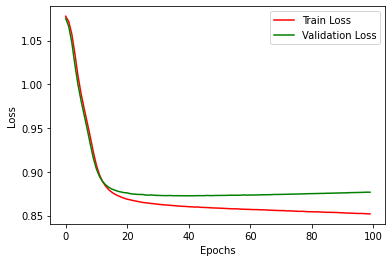

In [27]:
lossCurve(trainLosses,valLosses)